In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import ROOT
import uproot 
import awkward as ak
from pathlib import Path
import os
from tqdm import tqdm

Welcome to JupyROOT 6.26/06


In [2]:
file_path = "/home/dejavu/Projects/vertexing_sample/vertexperformance_AMVF_pu10_refitted_ontruth.root"
truth_tree_arrays = uproot.open(file_path)["Truth_Vertex_PV_Selected"].arrays()
refit_tree_arrays = uproot.open(file_path)["fitted_avg_pos_ontruth"].arrays()

In [3]:
def Get_local_PU_density(truth_vtx_vx, truth_vtx_vy, truth_vtx_vz, i_event, xyz_dist_window = 2.0):
    # Calculate the PU density around the truth HS vertex 
    residual_truth_vtx_vx = truth_vtx_vx[i_event] - truth_vtx_vx[i_event][0]
    residual_truth_vtx_vy = truth_vtx_vy[i_event] - truth_vtx_vy[i_event][0]
    residual_truth_vtx_vz = truth_vtx_vz[i_event] - truth_vtx_vz[i_event][0]
    
    dist_to_truth_HS = residual_truth_vtx_vx**2 + residual_truth_vtx_vy**2 + residual_truth_vtx_vz**2 
    n_local_truth = len(np.where(dist_to_truth_HS< xyz_dist_window**2)[0])
    return (n_local_truth - 1)/(2 * xyz_dist_window)

In [4]:
def Get_reco_info(reco_tree_arrays, type="truth_refitting"):
    reco_type = "reco_"

    if type == "truth_refitting":
        reco_vtx_vx = reco_tree_arrays["fitted_avg_pos_vtx_vx"]
        reco_vtx_vy = reco_tree_arrays['fitted_avg_pos_vtx_vy']
        reco_vtx_vz = reco_tree_arrays['fitted_avg_pos_vtx_vz']

        reco_trk_z0 = reco_tree_arrays['reco_vtx_fitted_trk_z0']
        reco_trk_qp = reco_tree_arrays["reco_vtx_fitted_trk_qp"]
        reco_trk_theta = reco_tree_arrays["reco_vtx_fitted_trk_theta"]
        reco_trk_trackWeight = reco_tree_arrays["reco_vtx_fitted_trk_trackWeight"]
        reco_trk_vtxID = reco_tree_arrays["reco_vtx_fitted_trk_vtxID"]

    return reco_vtx_vx, reco_vtx_vy, reco_vtx_vz, reco_trk_z0, reco_trk_qp, reco_trk_theta, reco_trk_trackWeight, reco_trk_vtxID

# Test the codes on refitting based on truth cluster 

In [5]:
vxMatchWeight = 0.7
cutMinTruthRecoRadialDiff = 0.1

def do_matching(truth_tree_arrays, reco_tree_arrays):
    hs_reco_eff = ROOT.TEfficiency("hs_reco_eff", "HS Reconstruction Efficiency; Local PU density; eff", 12, 0, 6)
    hs_sel_eff = ROOT.TEfficiency("hs_sel_eff", "HS Selection and Reconstruction Efficiency; Local PU density; eff", 12, 0, 6)

    test_event_idx = reco_tree_arrays.event_id
    PV_Classification = np.zeros((4),int)
    total_n_reco_vtx = 0
    n_recoed_hs_vtx = 0
    n_recoed_seled_hs_vtx = 0

    truth_vtx_vx = truth_tree_arrays['truth_vtx_vx']
    truth_vtx_vy = truth_tree_arrays['truth_vtx_vy']
    truth_vtx_vz = truth_tree_arrays['truth_vtx_vz']
    truth_trk_z0 = truth_tree_arrays['truth_vtx_fitted_trk_z0']
    truth_trk_vtxID = truth_tree_arrays['truth_vtx_fitted_trk_vtxID']

    reco_vtx_vx, reco_vtx_vy, reco_vtx_vz, reco_trk_z0, reco_trk_qp, reco_trk_theta, reco_trk_trackWeight, reco_trk_vtxID = Get_reco_info(refit_tree_arrays, type="truth_refitting")
    
    for i, event_id in enumerate(tqdm(test_event_idx)):            
        trk_reco_vtx_ID = ak.to_numpy(reco_trk_vtxID[i])
        trk_truth_vtx_ID = ak.to_numpy(truth_trk_vtxID[i])
        trk_pt_sq = ((1./reco_trk_qp[i])*np.sin(reco_trk_theta[i]))**2

        n_truth_vtx = len(truth_vtx_vz[i])
        n_reco_vtx = len(reco_vtx_vz[i])
        total_n_reco_vtx +=  n_reco_vtx
        Raw_RecoVertexMatchInfo = np.zeros((n_reco_vtx, n_truth_vtx, 3), dtype=float)
        for reco_vtx_id in range(n_reco_vtx):
            for truth_vtx_id in range(n_truth_vtx):
                trk_at_reco_id = np.where(trk_reco_vtx_ID == reco_vtx_id)[0]
                trk_at_truth_id = np.where(trk_truth_vtx_ID == truth_vtx_id)[0]
                intersect1, reco_common_idx1, truth_common_idx2 = np.intersect1d(
                    reco_trk_z0[i][trk_at_reco_id], 
                    truth_trk_z0[i][trk_at_truth_id], 
                    return_indices=True)

                Raw_RecoVertexMatchInfo[reco_vtx_id, truth_vtx_id, 0] = len(intersect1)
                Raw_RecoVertexMatchInfo[reco_vtx_id, truth_vtx_id, 1] = ak.sum(reco_trk_trackWeight[i][reco_common_idx1])
                Raw_RecoVertexMatchInfo[reco_vtx_id, truth_vtx_id, 2] = ak.sum(trk_pt_sq[reco_common_idx1])

        RecoVertexMatchInfo = np.copy(Raw_RecoVertexMatchInfo)
        RecoVertexMatchInfo[:,:,1] = Raw_RecoVertexMatchInfo[:,:,1] / Raw_RecoVertexMatchInfo[:,:,1].sum(axis = 0)
        RecoVertexMatchInfo[np.isnan(RecoVertexMatchInfo)[:,:,1]] = 0
        assigned_type = np.array([-1]*(n_reco_vtx))

        for reco_vtx_id in range(n_reco_vtx):      
            max_weight_idx = np.argmax(RecoVertexMatchInfo[:,:,1][reco_vtx_id])
            if RecoVertexMatchInfo[:,:,1][reco_vtx_id][max_weight_idx] > vxMatchWeight and RecoVertexMatchInfo[:,:,2][reco_vtx_id][max_weight_idx] == Raw_RecoVertexMatchInfo[reco_vtx_id,:,2].max():
                assigned_type[reco_vtx_id] = 0 # labelled as matched/clean 
            elif RecoVertexMatchInfo[:,:,1][reco_vtx_id][max_weight_idx] < vxMatchWeight and RecoVertexMatchInfo[:,:,2][reco_vtx_id][max_weight_idx] == Raw_RecoVertexMatchInfo[reco_vtx_id,:,2].max():
                assigned_type[reco_vtx_id] = 1 # labelled as merged
            else: 
                assigned_type[reco_vtx_id] = 2 # labelled as spilt 

        stat = np.bincount(assigned_type)
        for PV_type in range(len(stat)):
            PV_Classification[PV_type] += stat[PV_type]

        ### HS reco eff
        ind_best_reco_HS_nTrk = np.argmax(RecoVertexMatchInfo[:, 0, 0], axis = 0)
        ind_best_reco_HS_sumpt2 = np.argmax(RecoVertexMatchInfo[:,:,2].sum(axis=0))

        residual = np.array([reco_vtx_vx[i][ind_best_reco_HS_nTrk] - truth_vtx_vx[i][0],  
                             reco_vtx_vy[i][ind_best_reco_HS_nTrk] - truth_vtx_vy[i][0], 
                             reco_vtx_vz[i][ind_best_reco_HS_nTrk] - truth_vtx_vz[i][0]])

        ### Get PU density 
        local_PU_density = Get_local_PU_density(truth_vtx_vx=truth_vtx_vx, truth_vtx_vy=truth_vtx_vy, truth_vtx_vz=truth_vtx_vz, i_event = i)
        
        trhth_HS_vtx_recoed = False
        trhth_HS_vtx_recoed_seled = False
        if np.square(residual).sum() <= cutMinTruthRecoRadialDiff:
            n_recoed_hs_vtx += 1
            trhth_HS_vtx_recoed = True            
            if ind_best_reco_HS_nTrk == ind_best_reco_HS_sumpt2:
                n_recoed_seled_hs_vtx += 1 
                trhth_HS_vtx_recoed_seled = True

        hs_reco_eff.Fill(trhth_HS_vtx_recoed, local_PU_density)
        hs_sel_eff.Fill(trhth_HS_vtx_recoed and trhth_HS_vtx_recoed_seled, local_PU_density)



    assert np.sum(PV_Classification) == total_n_reco_vtx
    return PV_Classification, n_recoed_hs_vtx, n_recoed_seled_hs_vtx, hs_reco_eff, hs_sel_eff

In [6]:
PV_class, n_recoed_hs_vtx, n_recoed_seled_hs_vtx, hs_reco_eff, hs_sel_eff =  do_matching(truth_tree_arrays, reco_tree_arrays=refit_tree_arrays)

  2%|▏         | 224/10000 [00:06<05:06, 31.92it/s]/tmp/ipykernel_171161/1187639739.py:45: RuntimeWarning: invalid value encountered in divide
  RecoVertexMatchInfo[:,:,1] = Raw_RecoVertexMatchInfo[:,:,1] / Raw_RecoVertexMatchInfo[:,:,1].sum(axis = 0)
100%|██████████| 10000/10000 [05:35<00:00, 29.78it/s]


In [7]:
print(f"Fraction of successfully reconstruced HS vtx is {n_recoed_hs_vtx / len(truth_tree_arrays)}")
print(f"Fraction of successfully reconstruced and selected HS vtx is {n_recoed_seled_hs_vtx / len(truth_tree_arrays)}")

Fraction of successfully reconstruced HS vtx is 0.9863
Fraction of successfully reconstruced and selected HS vtx is 0.8039


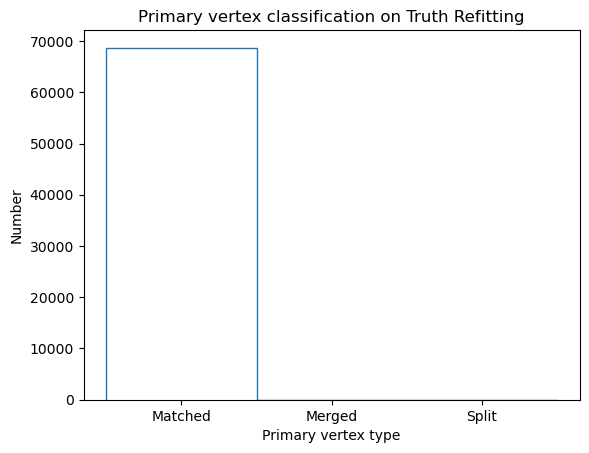

In [21]:
bins_edges = np.arange(0,4)
bin_centers = 0.5 * (bins_edges[:-1] + bins_edges[1:])
x_labels = ["Matched", "Merged", "Split"]
plt.stairs(PV_class[:-1])
plt.xticks(bin_centers, x_labels)
plt.title("Primary vertex classification on Truth Refitting")
plt.xlabel("Primary vertex type")
plt.ylabel("Number")
plt.show()

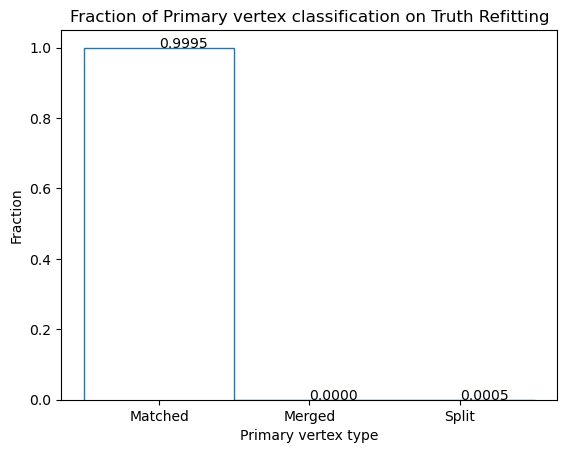

In [20]:
bin_centers = 0.5 * (bins_edges[:-1] + bins_edges[1:])
x_labels = ["Matched", "Merged", "Split"]
frac_pv = PV_class[:-1]/np.sum(PV_class[:-1])
plt.stairs(frac_pv)
plt.xticks(bin_centers, x_labels)
plt.title("Fraction of Primary vertex classification on Truth Refitting")
plt.xlabel("Primary vertex type")
plt.ylabel("Fraction")
for i, label in enumerate(x_labels):
    plt.text(bin_centers[i], frac_pv[i], f"{frac_pv[i]:.4f}")
plt.show()

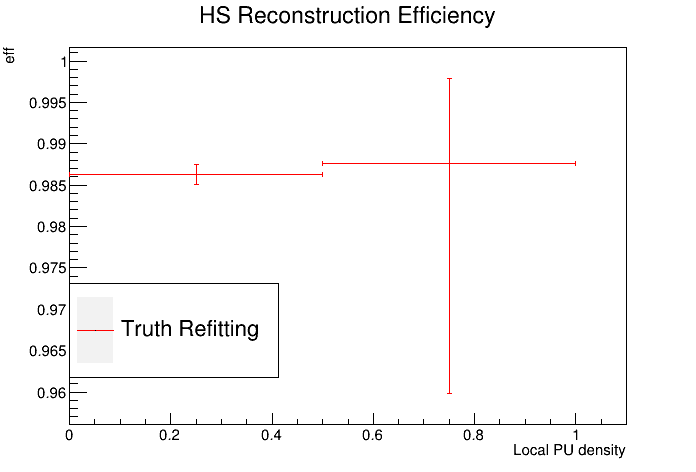

In [22]:
canvas_reco_eff = ROOT.TCanvas()
legend_reco_eff = ROOT.TLegend(0.1,0.2,0.4,0.4)

hs_reco_eff.SetLineColor(2)
hs_reco_eff.Draw()


legend_reco_eff.AddEntry(hs_reco_eff, "Truth Refitting")

legend_reco_eff.Draw("same")
canvas_reco_eff.Draw()

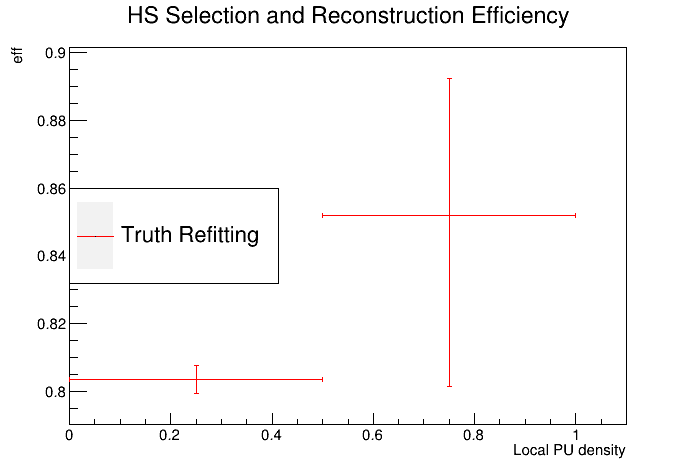

In [23]:
canvas_sel_eff = ROOT.TCanvas()
legend_sel_eff = ROOT.TLegend(0.1,0.4,0.4,0.6)

hs_sel_eff.SetLineColor(2)
hs_sel_eff.Draw()


legend_sel_eff.AddEntry(hs_sel_eff, "Truth Refitting")
legend_sel_eff.Draw("same")
canvas_sel_eff.Draw()